In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import statistics

import tensorflow as tf
from tensorflow import keras

from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.utils import class_weight

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import Pipeline as IMBPipeline

from scikeras.wrappers import KerasClassifier

from tpot import TPOTClassifier

2022-12-16 18:40:52.804495: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-16 18:40:55.883509: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-16 18:40:55.883529: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-16 18:40:56.157400: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-16 18:41:00.626816: W tensorflow/stream_executor/platform/de

In [2]:
CLASSES5 = ['angry', 'happy', 'neutral', 'sad', 'surprise']
CLASSES6 = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']
CLASSES7 = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


def load_data(ds, folder_name):
    # ds = 'all_en'
    isAug = False
    # folder_name = 'yamnet_emb'
    model_name = 'YAMNet'

    if 1 == 2:
        X_train = np.load(f'./features/{folder_name}/{ds}/train_aug_X.npy', allow_pickle=True)
        y_train = np.load(f'./features/{folder_name}/{ds}/train_aug_y.npy', allow_pickle=True)
    else:
        X_train = np.load(f'./features/{folder_name}/{ds}/train_X.npy', allow_pickle=True)
        y_train = np.load(f'./features/{folder_name}/{ds}/train_y.npy', allow_pickle=True)


    X_val = np.load(f'./features/{folder_name}/{ds}/val_X.npy', allow_pickle=True)
    y_val = np.load(f'./features/{folder_name}/{ds}/val_y.npy', allow_pickle=True)
    X_test = np.load(f'./features/{folder_name}/{ds}/test_X.npy', allow_pickle=True)
    y_test = np.load(f'./features/{folder_name}/{ds}/test_y.npy', allow_pickle=True)


    if ds == 'crema':
        classes = CLASSES6
    elif ds == 'bser':
        classes = CLASSES5
    else: 
        classes = CLASSES7

    # join train and val
    X_train = np.concatenate((X_train, X_val), axis=0)
    y_train = np.concatenate((y_train, y_val), axis=0)

    X = np.concatenate((X_train, X_test), axis=0)
    y = np.concatenate((y_train, y_test), axis=0)

    # print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

    # pca = PCA(n_components=0.70)

    # X_train = pca.fit_transform(X_train)
    # X_test = pca.transform(X_test)

    # X_train = X_train.reshape(X_train.shape[0], -1)
    # X_test = X_test.reshape(X_test.shape[0], -1)

    # X_train.shape, X_test.shape

    # class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    # # class_weights = dict(zip(np.unique(y_train), class_weights))
    # class_weights = dict(enumerate(class_weights))
    # sample_weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
    # sample_weights, len(sample_weights)

    return X, y

In [ ]:
# from sklearn.preprocessing import LabelEncoder


# X, y = load_data('savee', 'vggish_emb')
# train_X, test_X, train_y, test_y =train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# sample_weights = class_weight.compute_sample_weight(class_weight='balanced', y=train_y)

# enc = LabelEncoder()
# train_y = enc.fit_transform(train_y)
# test_y = enc.transform(test_y)

# tpot = TPOTClassifier(generations=5, population_size=20, verbosity=2, n_jobs=-1, scoring='f1_weighted',)
# tpot.fit(train_X, train_y, sample_weight=sample_weights)
# tpot.score(test_X, test_y)
# tpot.export('tpot_ravdess_pipeline.py')

In [3]:
def get_sampling_count(y):
    count = Counter(y)
    harmonic_mean = round(statistics.harmonic_mean(count.values()))

    us_sample_count = {}
    os_sample_count = {}

    for key, value in count.items():
        if value > harmonic_mean:
            us_sample_count[key] = harmonic_mean
        elif value < harmonic_mean:
            os_sample_count[key] = harmonic_mean
        else:
            continue

    return us_sample_count, os_sample_count

In [4]:
def evaluate(model, X_test, y_test, classes, title ):

    preds = model.predict(X_test)

    weighted_f1 = f1_score(y_test, preds, average='weighted')
    macro_f1 = f1_score(y_test, preds, average='macro')
    micro_f1 = f1_score(y_test, preds, average='micro')
    accuracy = accuracy_score(y_test, preds)
    print('F1 Scores')
    print('---------')
    print(f'Weighted: {weighted_f1}')
    print(f'Macro: {macro_f1} (Equal weights to each class)')
    print(f'Micro: {micro_f1}')
    print(f'Accuracy: {accuracy}')

    # weighted_auc = roc_auc_score(y_test, preds, average='weighted', multi_class='ovr')
    # macro_auc = roc_auc_score(y_test, preds, average='macro', multi_class='ovr')
    # micro_auc = roc_auc_score(y_test, preds, average='micro', multi_class='ovr')
    # print('AUC Scores')
    # print('---------')
    # print(f'Weighted: {weighted_auc}')
    # print(f'Macro: {macro_auc} (Equal weights to each class)')
    # print(f'Micro: {micro_auc}')


    print('\n')
    print('Classification Report')
    print('---------------------')
    print(classification_report(y_test,preds, digits=4))


    print('\n')
    print('Confusion Matrix')
    print('----------------')
    cm = confusion_matrix(y_test, preds)

    cm = cm / cm.astype(float).sum(axis=1)

    sns.set(font_scale=1.5)

    fig, ax= plt.subplots(figsize=(15,8))
    sns.heatmap(cm, annot=True, fmt='.2g', ax=ax)

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix of ' + title); 
    ax.xaxis.set_ticklabels(classes)
    ax.yaxis.set_ticklabels(classes)
    plt.show()

    return weighted_f1

(35593, 128) (35593,)


/home/sam/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

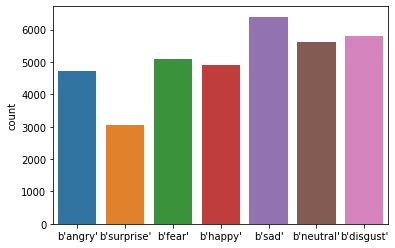

In [5]:
a,b = load_data('all', 'vggish_emb')

print(a.shape, b.shape)

sns.countplot(b)


In [ ]:
smt = SMOTETomek(sampling_strategy='all')

X_res, y_res = smt.fit_resample(a, b)

print(X_res.shape, y_res.shape)

sns.countplot(y_res)

## Classic ML Models

In [ ]:
dses = ['tess', 'ravdess', 'savee', 'crema', 'subesco', 'bser', 'all_bn', 'all_en', 'all']
folder_names = ['yamnet_emb']

models = [
    {
        'name': 'Logistic Regression V1',
        'model': LogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight='balanced'),
        'scale': True
    },
    {
        'name': 'Logistic Regression V2',
        'model': LogisticRegression(max_iter = 500, tol=1e-5, C=1.5, multi_class='multinomial', solver='lbfgs', class_weight='balanced'),
        'scale': True
    },
    {
        'name': 'Logistic Regression V3',
        'model': LogisticRegression(max_iter = 1000, tol=1e-5,C=2, multi_class='multinomial', solver='lbfgs', class_weight='balanced'),
        'scale': True
    },
    {
        'name': 'Logistic Regression V4',
        'model': LogisticRegression(max_iter = 2000,tol=1e-5, C=2.5, multi_class='multinomial', solver='lbfgs', class_weight='balanced'),
        'scale': True
    },

]

scores = [
    'accuracy',
    'f1_weighted',
]
# metrics.get_scorer_names()

In [ ]:
pipeline = IMBPipeline([
    ('balance', SMOTETomek(sampling_strategy='all')),
    ('clf', MLPClassifier())
])

params = {
    'clf__hidden_layer_sizes': [(1024,), (512,), (2048,)],
    'clf__learning_rate': ['adaptive', 'invscaling'],
    'clf__learning_rate_init': [0.0001, 1e-5],
    'clf__max_iter': [1000],
    'clf__shuffle': [True],
}

scv = StratifiedKFold(n_splits=5)

grid = GridSearchCV(pipeline, params, cv=scv, scoring=scores, refit='f1_weighted', n_jobs=-1, verbose=1, return_train_score=True)

X, y = load_data('all', 'vggish_emb')

grid.fit(X, y)

In [ ]:
grid.best_params_

In [ ]:
df = pd.DataFrame(grid.cv_results_)
df = df.sort_values(by='mean_test_f1_weighted', ascending=False)
df
# df.to_csv('grid_search_results_savee.csv', index=False)

In [ ]:
# reses = []
# for folder_name in folder_names:
#     for ds in dses:
#         X, y = load_data(ds, folder_name)
#         scv = StratifiedKFold(n_splits=5, shuffle=True)
#         for model in models:
#             print('Cross validating', model['name'], 'on', ds, 'with', folder_name)

#             if model['scale']:
#                 scaler = StandardScaler()
#                 X = scaler.fit_transform(X)

#             acc = []
#             f1_weighted = []

#             for train_index, test_index in scv.split(X, y):
#                 X_train, X_test = X[train_index], X[test_index]
#                 y_train, y_test = y[train_index], y[test_index]

#                 us_sample_count, os_sample_count = get_sampling_count(y_train)

#                 # over = RandomOverSampler(sampling_strategy=os_sample_count)
#                 # X_train, y_train = over.fit_resample(X_train, y_train)

#                 # under = RandomUnderSampler(sampling_strategy=us_sample_count)
#                 # X_train, y_train = under.fit_resample(X_train, y_train)

#                 smt = SMOTETomek(sampling_strategy='all')
#                 X_train, y_train = smt.fit_resample(X_train, y_train)

#                 m = model['model']
#                 m.fit(X_train, y_train)

#                 acc.append(accuracy_score(y_test, m.predict(X_test)))
#                 f1_weighted.append(f1_score(y_test, m.predict(X_test), average='weighted'))

#             reses.append({
#                 'ds': ds,
#                 'model': model['name'],
#                 'folder': folder_name,
#                 'weighted_f1': np.mean(f1_weighted),
#                 'accuracy': np.mean(acc),
#             })

In [ ]:
# import pickle

# with open('results.pkl', 'wb') as f:
#     pickle.dump(reses, f)

In [ ]:
reses[0]

In [ ]:
df = pd.read_csv('grid_search_results.csv')
df

In [ ]:
sns.set(font_scale=1.5)
df_dict = {
    'model': [],
    'dataset': [],
    'folder': [],
    'accuracy': [],
    'f1_weighted': [],
    'train_time': []
}

for res in reses:
    df_dict['model'].append(res['model'])
    df_dict['dataset'].append(res['ds'])
    df_dict['folder'].append(res['folder'])
    df_dict['f1_weighted'].append(res['weighted_f1'])
    df_dict['accuracy'].append(res['accuracy'])



df = pd.DataFrame(reses)
df

In [ ]:
sns.set(font_scale=1.5)
plt.figure(figsize=(50,20))
ax = sns.barplot(x='ds', y='weighted_f1', hue='model', data=df[df['folder'] == 'vggish_emb'])
plt.title('Weighted F1 Scores for VGGish Embeddings')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
            ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    if p.get_height() > 6:
        p.set_color('red')    


In [ ]:
plt.figure(figsize=(50,20))
ax = sns.barplot(x='ds', y='accuracy', hue='model', data=df[df['folder'] == 'vggish_emb'])
plt.title('Accuracy of different models on different datasets with VGGish embeddings')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
            ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')


In [ ]:
plt.figure(figsize=(50,20))
ax = sns.barplot(x='ds', y='weighted_f1', hue='model', data=df[df['folder'] == 'yamnet_emb'])
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
            ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')


In [ ]:
plt.figure(figsize=(50,20))
ax = sns.barplot(x='dataset', y='train_time', hue='model', data=df[df['folder'] == 'yamnet_emb'])
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.4f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
            ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')


## Keras

In [17]:
isAug = False
ds = 'all'
folder_name = 'vggish_emb'

if isAug:
    train_features = np.load(f'./features/{folder_name}/{ds}/train_aug_X.npy', allow_pickle=True)
    train_labels = np.load(f'./features/{folder_name}/{ds}/train_aug_y.npy', allow_pickle=True)
else:
    train_features = np.load(f'./features/{folder_name}/{ds}/train_X.npy', allow_pickle=True)
    train_labels = np.load(f'./features/{folder_name}/{ds}/train_y.npy', allow_pickle=True)


val_features = np.load(f'./features/{folder_name}/{ds}/val_X.npy', allow_pickle=True)
val_labels = np.load(f'./features/{folder_name}/{ds}/val_y.npy', allow_pickle=True)
test_features = np.load(f'./features/{folder_name}/{ds}/test_X.npy', allow_pickle=True)
test_labels = np.load(f'./features/{folder_name}/{ds}/test_y.npy', allow_pickle=True)

scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)


labels = np.unique(train_labels)

class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=labels, y=train_labels)
# class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights = dict(enumerate(class_weights))
sample_weights = class_weight.compute_sample_weight(class_weight='balanced', y=train_labels)

print(class_weights)
print(sample_weights.shape)

train_labels = train_labels.reshape(-1, 1)
val_labels = val_labels.reshape(-1, 1)
test_labels = test_labels.reshape(-1, 1)

encoder = OneHotEncoder()

train_labels = encoder.fit_transform(train_labels).toarray()
val_labels = encoder.transform(val_labels).toarray()
test_labels = encoder.transform(test_labels).toarray()

print('Training features shape:', train_features.shape)
print('Training labels shape:', train_labels.shape)
print('Validation features shape:', val_features.shape)
print('Validation labels shape:', val_labels.shape)
print('Test features shape:', test_features.shape)
print('Test labels shape:', test_labels.shape)

def plot_cm(labels, predictions):
    cm = confusion_matrix(labels, predictions)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(15,8))
    sns.heatmap(cm, annot=True, fmt=".2g")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'), 
    # keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.CategoricalAccuracy(name="categorical_accuracy", dtype=None),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


{0: 1.076147382029735, 1: 0.8737273013540464, 2: 1.0043436293436294, 3: 1.03045308244615, 4: 0.9095942303489474, 5: 0.78960349079871, 6: 1.6827493261455526}
(24972,)
Training features shape: (24972, 128)
Training labels shape: (24972, 7)
Validation features shape: (3536, 128)
Validation labels shape: (3536, 7)
Test features shape: (7085, 128)
Test labels shape: (7085, 7)


2022-11-24 17:53:36.964117: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-24 17:53:36.964354: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-24 17:53:36.964421: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-11-24 17:53:36.964473: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-11-24 17:53:36.964521: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [31]:
EPOCHS = 5000
BATCH_SIZE = 256
monitor = 'val_loss'

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor=monitor, 
    verbose=1,
    patience=20,
    mode='min',
    restore_best_weights=True)

scheduling = keras.callbacks.ReduceLROnPlateau(
    monitor=monitor,
    factor=0.5,
    patience=3,
    cooldown=0,
    verbose=1,
    mode="min",
    min_delta=0.0001,
    min_lr=1e-20
    )

def create_model(layers, dropout):

    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(1024,)))

    for i in range(len(layers)):
        model.add(keras.layers.Dense(layers[i], activation='relu'))

    model.add(keras.layers.Dropout(dropout))
    model.add(keras.layers.Dense(7, activation='softmax'))

    return model


In [19]:
layers = [
    [2048],
    [1024],
    [512],
    [256],
    [128],
    [512, 256],
    [128, 256]
]
dropouts = [0, 0.2, 0.5]
optimizers = [
    tf.optimizers.Adam(learning_rate=1e-3),
    tf.optimizers.Adamax(learning_rate=1e-3),
    tf.optimizers.Adam(learning_rate=1e-4),
    tf.optimizers.Adamax(learning_rate=1e-4),
    tf.optimizers.Adam(learning_rate=1e-5),
    tf.optimizers.Adamax(learning_rate=1e-5),
]
dses = ['tess', 'ravdess', 'savee', 'crema', 'subesco', 'bser', 'all_bn', 'all_en', 'all']
folder_names = ['vggish_emb']
isAugs = [True, False]

In [ ]:
import itertools

combinations = list(itertools.product(layers, dropouts, optimizers, dses, folder_names, isAugs))

len(combinations), combinations[0]

In [ ]:
from tqdm import tqdm

results = []

for comb in tqdm(combinations):
    print(comb)
    layer, dropout, optimizer, ds, folder_name, isAug = comb

    if isAug:
        train_features = np.load(f'./features/{folder_name}/{ds}/train_aug_X.npy', allow_pickle=True)
        train_labels = np.load(f'./features/{folder_name}/{ds}/train_aug_y.npy', allow_pickle=True)
    else:
        train_features = np.load(f'./features/{folder_name}/{ds}/train_X.npy', allow_pickle=True)
        train_labels = np.load(f'./features/{folder_name}/{ds}/train_y.npy', allow_pickle=True)


    val_features = np.load(f'./features/{folder_name}/{ds}/val_X.npy', allow_pickle=True)
    val_labels = np.load(f'./features/{folder_name}/{ds}/val_y.npy', allow_pickle=True)
    test_features = np.load(f'./features/{folder_name}/{ds}/test_X.npy', allow_pickle=True)
    test_labels = np.load(f'./features/{folder_name}/{ds}/test_y.npy', allow_pickle=True)


    labels = np.unique(train_labels)

    scaler = StandardScaler()
    train_features = scaler.fit_transform(train_features)
    val_features = scaler.transform(val_features)
    test_features = scaler.transform(test_features)
    train_labels = train_labels.reshape(-1, 1)
    val_labels = val_labels.reshape(-1, 1)
    test_labels = test_labels.reshape(-1, 1)
    
    encoder = OneHotEncoder()
    train_labels = encoder.fit_transform(train_labels).toarray()
    val_labels = encoder.transform(val_labels).toarray()
    test_labels = encoder.transform(test_labels).toarray()


    # Model creation
    out = len(labels)

    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(train_features.shape[-1],)))

    for i in range(len(layers)):
        model.add(keras.layers.Dense(layers[i][0], activation='relu'))
    
    if dropout != 0:
        model.add(keras.layers.Dropout(dropout))

    model.add(keras.layers.Dense(out, activation='softmax'))

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=METRICS
    )
    model.fit(train_features, train_labels, validation_data=(val_features, val_labels), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping, scheduling], verbose=0)

    res = model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)

    test_predictions = model.predict(test_features, batch_size=BATCH_SIZE)
    true = encoder.inverse_transform(test_labels)
    preds = encoder.inverse_transform(test_predictions)

    results.append(
        {
            'info': comb,
            'res': res,
            'f1_weighted': f1_score(true, preds, average='weighted'),
            'accuracy': accuracy_score(true, preds),
            'cm': confusion_matrix(true, preds, normalize='true'),
            'report': classification_report(true, preds, digits=4)
        }
    )


before: (84649, 1024) (84649,)


/home/sam/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


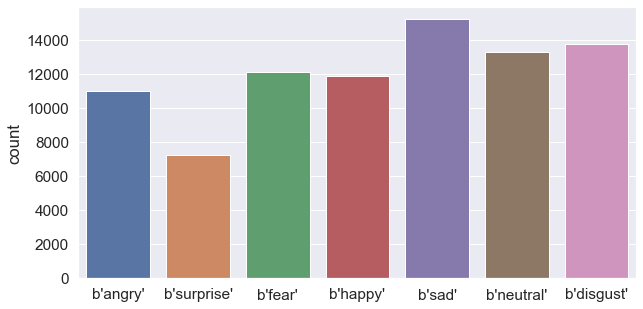

After: (80598, 1024) (80598,)


/home/sam/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


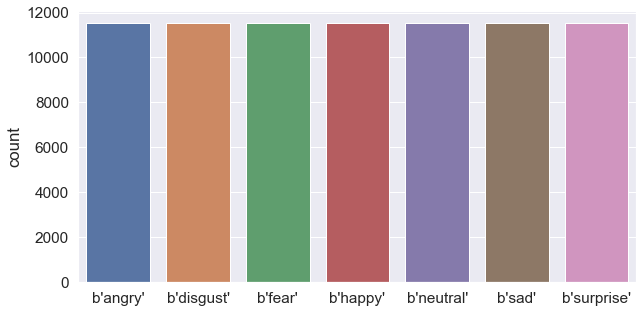

In [7]:
folder_name = 'yamnet_emb'
ds = 'all'

train_features = np.load(f'./features/{folder_name}/{ds}/train_X.npy', allow_pickle=True)
train_labels = np.load(f'./features/{folder_name}/{ds}/train_y.npy', allow_pickle=True)
val_features = np.load(f'./features/{folder_name}/{ds}/val_X.npy', allow_pickle=True)
val_labels = np.load(f'./features/{folder_name}/{ds}/val_y.npy', allow_pickle=True)
test_features = np.load(f'./features/{folder_name}/{ds}/test_X.npy', allow_pickle=True)
test_labels = np.load(f'./features/{folder_name}/{ds}/test_y.npy', allow_pickle=True)

print('before:', train_features.shape, train_labels.shape)
plt.figure(figsize=(10, 5))
sns.set(font_scale=1.4)
sns.countplot(train_labels)
plt.show()
under, over = get_sampling_count(train_labels)
under_sample = RandomUnderSampler(sampling_strategy=under)
over_sample = RandomOverSampler(sampling_strategy=over)
train_features, train_labels = under_sample.fit_resample(train_features, train_labels)
train_features, train_labels = over_sample.fit_resample(train_features, train_labels)
print('After:', train_features.shape, train_labels.shape)
plt.figure(figsize=(10, 5))
sns.countplot(train_labels)
plt.show()

scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)
train_labels = train_labels.reshape(-1, 1)
val_labels = val_labels.reshape(-1, 1)
test_labels = test_labels.reshape(-1, 1)

encoder = OneHotEncoder()
train_labels = encoder.fit_transform(train_labels).toarray()
val_labels = encoder.transform(val_labels).toarray()
test_labels = encoder.transform(test_labels).toarray()


In [32]:
model = create_model([4096, 2048, 1024], 0.2)
model.compile(
    optimizer=tf.optimizers.Adamax(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=METRICS
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 4096)              4198400   
                                                                 
 dense_8 (Dense)             (None, 2048)              8390656   
                                                                 
 dense_9 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_10 (Dense)            (None, 7)                 7175      
                                                                 
Total params: 14,694,407
Trainable params: 14,694,407
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist = model.fit(
    train_features, 
    train_labels, 
    validation_data=(val_features, val_labels), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    callbacks=[early_stopping, scheduling], 
    verbose=1)


In [34]:
model.save('../Models/yamnet_all')

INFO:tensorflow:Assets written to: ../Models/yamnet_all/assets


94/94 [==============================] - 6s 63ms/step


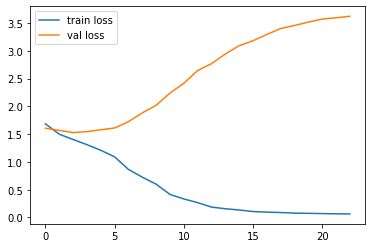

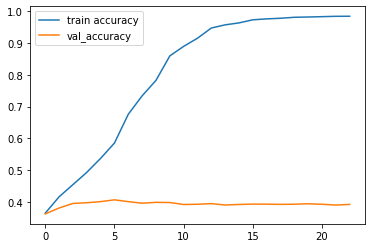

loss :  1.5264936685562134
tp :  3875.0
fp :  2195.0
tn :  142159.0
fn :  20184.0
categorical_accuracy :  0.3894592523574829
precision :  0.6383854746818542
recall :  0.16106238961219788
auc :  0.7873979210853577
prc :  0.4220905303955078


In [35]:
# train_predictions = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions = model.predict(test_features, batch_size=BATCH_SIZE)

plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.legend()
plt.show()

plt.plot(hist.history['categorical_accuracy'], label='train accuracy')
plt.plot(hist.history['val_categorical_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

res = model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(model.metrics_names, res):
  print(name, ': ', value)


F1 Scores
---------
Weighted: 0.3832461572151023
Macro: 0.3877691018913804 (Equal weights to each class)
Micro: 0.38945924602020027
Accuracy: 0.3894592460202003

Accuracy Score
--------------
Accuracy:  38.945924602020035
              precision    recall  f1-score   support

    b'angry'     0.4934    0.4538    0.4728      3138
  b'disgust'     0.3606    0.2115    0.2666      3858
     b'fear'     0.3138    0.4590    0.3727      3436
    b'happy'     0.3576    0.3604    0.3590      3349
  b'neutral'     0.4552    0.5217    0.4862      3830
      b'sad'     0.4263    0.2844    0.3412      4262
 b'surprise'     0.3467    0.5197    0.4159      2186

    accuracy                         0.3895     24059
   macro avg     0.3934    0.4015    0.3878     24059
weighted avg     0.3963    0.3895    0.3832     24059



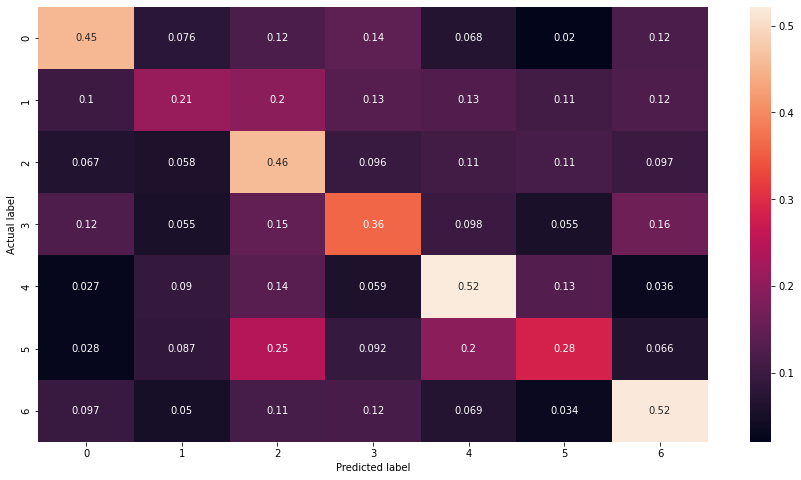

In [36]:

true = encoder.inverse_transform(test_labels)
preds = encoder.inverse_transform(test_predictions)

mlp_weighted_f1 = f1_score(true, preds, average='weighted')
mlp_macro_f1 = f1_score(true, preds, average='macro')
mlp_micro_f1 = f1_score(true, preds, average='micro')
mlp_accuracy = accuracy_score(true, preds)
print('F1 Scores')
print('---------')
print(f'Weighted: {mlp_weighted_f1}')
print(f'Macro: {mlp_macro_f1} (Equal weights to each class)')
print(f'Micro: {mlp_micro_f1}')
print(f'Accuracy: {mlp_accuracy}')

print()
print('Accuracy Score')
print('--------------')
mlp_acc = accuracy_score(true, preds) * 100
print('Accuracy: ', mlp_acc)

print(classification_report(true, preds, digits=4))
plot_cm(true, preds)

## Comparison

In [37]:
f1s = {
    'SVM': svm_f1 * 100,
    'Logistic Regression': lr_f1 * 100,
    'MLP': mlp_weighted_f1 * 100
}


accuracies = {
    'SVM': svm_test_acc,
    'Logistic Regression': lrm_test_acc,
    'MLP': mlp_acc
}

plt.figure(figsize=(15, 8))
ax = sns.barplot(y=list(accuracies.values()), x=list(accuracies.keys()))
plt.title('Accuracy Scores')
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

plt.figure(figsize=(15, 8))
ax = sns.barplot(y=list(f1s.values()), x=list(f1s.keys()))
for i in ax.containers:
    ax.bar_label(i,)
plt.title('Weighted F1 Scores')
plt.show()



NameError: name 'svm_f1' is not defined

In [ ]:
import pickle

with open('/home/sam/Documents/Projects/Thesis/audio-preprocessing-and-feature-extraction/results/vggish/bser.pkl', 'rb') as f:
    r = pickle.load(f)

In [ ]:
df = pd.DataFrame(r)
df = df.sort_values(by=['f1_weighted'], ascending=False)
df

In [ ]:
df['info'][5]